# Deep learning framework example

This notebook demonstrates how to use the deeplearning API to train and test the model on the [Iris dataset](https://archive.ics.uci.edu/ml/datasets/iris).

To install the necessary software, use `make deps` in the root directory of the project.  If you don't have make installed or don't want to use it, then use:

`pip install -r src/python/requirements.txt`

In [1]:
# set up notebook environment
import sys
app_root_dir = '..'
sys.path.append(app_root_dir + '/src/python')
sys.path.append(app_root_dir + '/test/python')

import torch
# set the random seed so things are predictable
torch.manual_seed(7)

## Create the object factory

This creates a factoty that instantiates Python objects using a simple configuration (INI).  This removes much of the complexity of creating and "hooking up" all the instances.

In [2]:
import logging
from zensols.config import ExtendedInterpolationEnvConfig as AppConfig
from zensols.config import ImportConfigFactory
from zensols.deeplearn import ModelResultGrapher

# configure the environment
config = AppConfig(app_root_dir + '/test-resources/iris/iris.conf',
                   env={'app_root': app_root_dir})

# create a factoty that instantiates Python objects using a simple configuration (INI)
factory = ImportConfigFactory(config, shared=True)

## Create the model executor

Use the factory to create the model executor (see the `executor` section of `test-resources/iris/iris.conf`).  The `write` method gives statistics on the data set that is configured on the executor.

In [3]:
executor = factory('executor')
executor.write()

feature splits:
    data frame splits:
        dev: 12 (8.0%)
        test: 25 (16.7%)
        train: 113 (75.3%)
        total: 150
batch splits:
    split stash splits:
        dev: 1 (11.1%)
        test: 2 (22.2%)
        train: 6 (66.7%)
        total: 9
    total this instance: 9
    keys consistent: True


## Print the model

Every time the executor is told to train, it creates a new model.  It also stores this model to the disk every time the validation loss drops.  The method that controls the creation if `create_model`.  Note this creates a new PyTorch `torch.nn.Module` every time and isn't the same instance used by the executor.

In this case, a four deep fully connected network is created and fanned out from the 4 features (from four columns from the CSV file) to 20.  This is then reduce to the output layer having three neurons indicating which type of flower (setosa, versicolor, or virginica).

In [4]:
print(executor.create_model())

IrisNetwork(
  (fc): DeepLinearLayer(
    (seq_layers): Sequential(
      (0): Linear(in_features=4, out_features=20, bias=True)
      (1): Linear(in_features=20, out_features=20, bias=True)
      (2): Linear(in_features=20, out_features=3, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
)


## Train and test the model

This trains the model on the Iris (flower) data set and prints the results.  The PyTorch model itself is also printed.

train: 0.402, valid: 0.146 /\: 100%|███████████| 50/50 [00:00<00:00, 64.31it/s]


Name: Iris
Run index: 1
Learning rate: 0.05
    train:
        started: 05/19/2020 03:32:47:064249
        ended: 05/19/2020 03:32:47:842458
        num epochs: 50
        num data points per epoc: 113
        loss: 0.003396190618262499
        num outcomes: 5650
        epoch convergence: 39
        micro: F1: 0.722, precision: 0.72, recall: 0.72
        macro: F1: 0.725, precision: 0.73, recall: 0.72
    validation:
        num epochs: 50
        num data points per epoc: 12
        loss: 0.02356753811240196
        num outcomes: 600
        epoch convergence: 47
        micro: F1: 0.885, precision: 0.89, recall: 0.89
        macro: F1: 0.896, precision: 0.89, recall: 0.91
    test:
        started: 05/19/2020 03:32:47:917735
        ended: 05/19/2020 03:32:47:919046
        num epochs: 1
        num data points per epoc: 25
        loss: 0.007457316040992736
        num outcomes: 25
        epoch convergence: 0
        micro: F1: 0.960, precision: 0.96, recall: 0.96
        macro: F

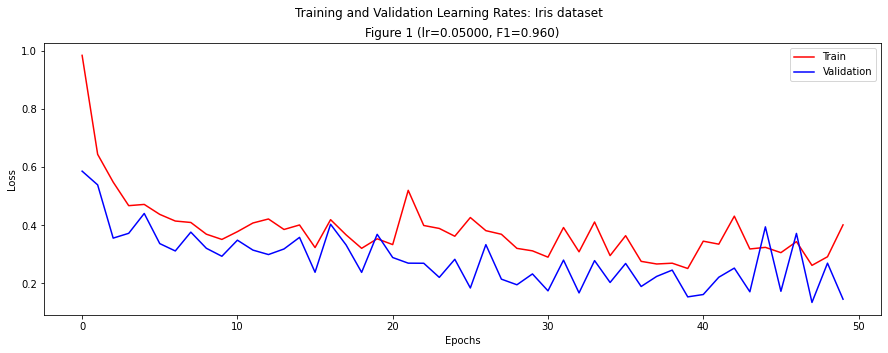

In [5]:
# tell the executor to give us console output
executor.progress_bar = True

# train the model
executor.train()

# test the model
res = executor.test()

# write a summary of the results
res.write()

# graph the results
grapher = ModelResultGrapher('Iris dataset', [15, 5])
grapher.plot([res])

## Fine tune setting hyperparameters

Now that we have our model training and we have evaluated the results, we see the validation loss is very spiky.  This means our learning rate is probably too high as when it moves during stochastic gradient descent it is "jumping" too far and back up the error surface.

To fix that, let's decrease the learning rate.  We'll probably end up modifying many of these kinds of parameters, so let's write a few functions to automate this for us.

train: 0.313, valid: 0.303 \/: 100%|█████████| 200/200 [00:05<00:00, 37.45it/s]


Name: Iris
Run index: 2
Learning rate: 0.001
    train:
        started: 05/19/2020 03:32:48:327953
        ended: 05/19/2020 03:32:53:669589
        num epochs: 200
        num data points per epoc: 113
        loss: 0.0036007954321678553
        num outcomes: 22600
        epoch convergence: 175
        micro: F1: 0.733, precision: 0.73, recall: 0.73
        macro: F1: 0.731, precision: 0.73, recall: 0.73
    validation:
        num epochs: 200
        num data points per epoc: 12
        loss: 0.031547972249488035
        num outcomes: 2400
        epoch convergence: 199
        micro: F1: 0.917, precision: 0.92, recall: 0.92
        macro: F1: 0.924, precision: 0.92, recall: 0.94
    test:
        started: 05/19/2020 03:32:53:804948
        ended: 05/19/2020 03:32:53:806282
        num epochs: 1
        num data points per epoc: 25
        loss: 0.010675960302352905
        num outcomes: 25
        epoch convergence: 0
        micro: F1: 0.920, precision: 0.92, recall: 0.92
       

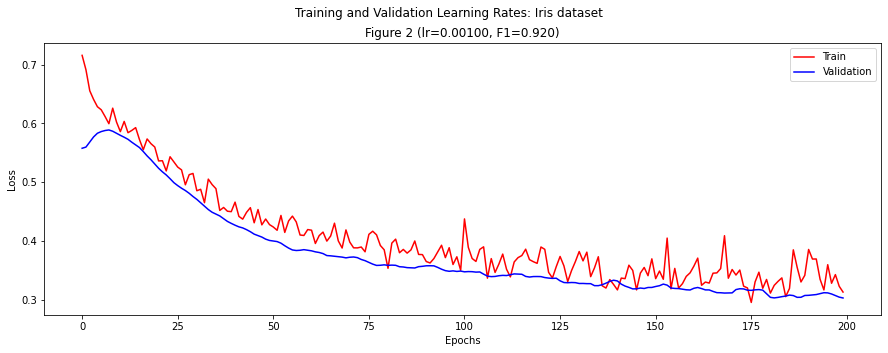

In [6]:
def set_model(name: str, value):
    # all values in the configuration are string (constraint of configparser), then later parsed to types
    value = str(value)
    config.set_option(name=name, value=value, section='model_settings')

def set_net(name: str, value):
    value = str(value)
    config.set_option(name=name, value=value, section='net_settings')

def run_model():
    # clear the previous cached version of the executor in order to create a new one so we pick up the change
    factory.shared.clear()
    executor = factory('executor', progress_bar=True)
    # train/test
    executor.train()
    res = executor.test()
    # results
    res.write()
    grapher = ModelResultGrapher('Iris dataset', [15, 5])
    grapher.plot([res])

# set the number of epochs and learning rate, which are both model parameters
set_model('epochs', 200)
set_model('learning_rate', .001)

# run the model with the new
run_model()

## Network parameters

While we're at it, let's also adjust the drop out to see if we can get better results.  Also note that the model converged pretty late (194) indicating we aren't get over training, so add more epochs.

train: 0.303, valid: 0.267 /\: 100%|█████████| 300/300 [00:09<00:00, 31.96it/s]


Name: Iris
Run index: 3
Learning rate: 0.001
    train:
        started: 05/19/2020 03:32:54:192588
        ended: 05/19/2020 03:33:03:578698
        num epochs: 300
        num data points per epoc: 113
        loss: 0.0034726662517448196
        num outcomes: 33900
        epoch convergence: 289
        micro: F1: 0.747, precision: 0.75, recall: 0.75
        macro: F1: 0.745, precision: 0.74, recall: 0.75
    validation:
        num epochs: 300
        num data points per epoc: 12
        loss: 0.029592634364962577
        num outcomes: 3600
        epoch convergence: 294
        micro: F1: 0.888, precision: 0.89, recall: 0.89
        macro: F1: 0.902, precision: 0.90, recall: 0.93
    test:
        started: 05/19/2020 03:33:03:753976
        ended: 05/19/2020 03:33:03:755359
        num epochs: 1
        num data points per epoc: 25
        loss: 0.010009395599365234
        num outcomes: 25
        epoch convergence: 0
        micro: F1: 0.960, precision: 0.96, recall: 0.96
       

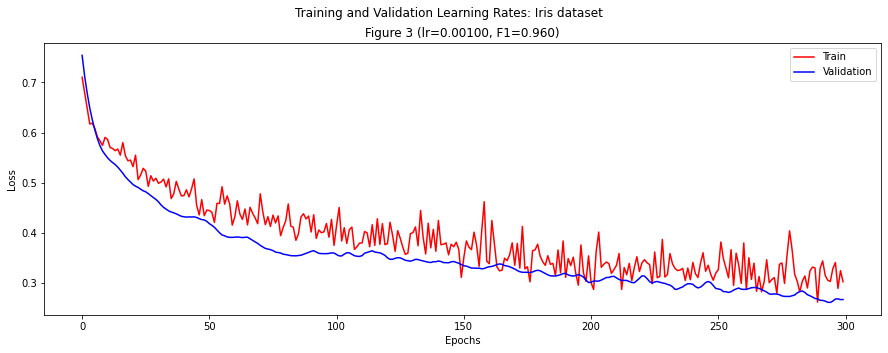

In [7]:
# set a network parameter
set_net('dropout', .1)
set_model('epochs', 300)
run_model()